In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(0)
data_dir = "data"
batch_size = 128

In [4]:
trainset = ImageFolder(data_dir, transform=transforms.Compose([
    transforms.ToTensor()]))
print("数据个数:{}".format(len(trainset)))

数据个数:6763


In [5]:
dataloader = DataLoader(trainset, batch_size, shuffle=True, pin_memory=True)

In [5]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images*0.5+0.5, nrow=16).permute(1, 2, 0))
        writer = SummaryWriter("logs")
        writer.add_image("dataloader", make_grid(images*0.5+0.5, nrow=16), 1)
        writer.close()
        break

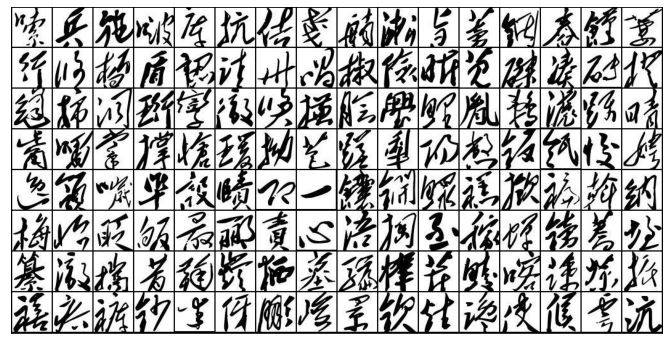

In [6]:
show_batch(dataloader)

In [7]:
def weights_init(item):
    classname = item.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(item.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(item.weight.data, 1.0, 0.02)
        nn.init.constant_(item.bias.data, 0)
    

### 生成器

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(100, 64*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.network(input)


In [4]:
device=torch.device('cuda'if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
writer = SummaryWriter("logs")
writer.add_graph(G, input_to_model=torch.rand(1,100,1,1).to(device))
writer.close()


NameError: name 'Generator' is not defined

In [10]:
G.apply(weights_init)

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )

### 判别器

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.network(input)

In [12]:
D = Discriminator().to(device)
D.apply(weights_init)

Discriminator(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

### 损失函数


In [13]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0
learning_rate = 0.0002

optimizerD = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5,0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5,0.999))

In [21]:
num_epochs = 10
G_losses = []
D_losses = []
D_x_list = []
D_z_list = []
img_list = []
loss_tep = 100

for epoch in range(num_epochs):
    print("--------第{}轮--------".format(epoch+1))
    for i, data in enumerate(dataloader):
        #(1)训练判别器
        D.zero_grad()
        imgs = data[0].to(device)
        b_size = imgs.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = D(imgs).view(-1)
        lossD_real = criterion(output, label)
        lossD_real.backward()
        D_x = output.mean().item()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = G(noise)
        label.fill_(fake_label)
        output = D(fake.detach()).view(-1)
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        DtoG = output.mean().item()
        lossD = lossD_real + lossD_fake
        optimizerD.step()

        #(2)训练生成器
        G.zero_grad()
        label.fill_(real_label)
        output = D(fake).view(-1)
        lossG = criterion(output, label)
        lossG.backward()
        GtoD = output.mean().item()
        optimizerG.step()
        
        print(
            f'Epoch: [{epoch+1:0>{len(str(num_epochs))}}/{num_epochs}]',
            f'Step: [{i+1:0>{len(str(len(dataloader)))}}/{len(dataloader)}]',
            f'Loss-D: {lossD.item():.4f}',
            f'Loss-G: {lossG.item():.4f}',
            f'D(x): {D_x:.4f}',
            f'D(G(z)): [{DtoG:.4f}/{GtoD:.4f}]',
        )

        G_losses.append(lossG.item())
        D_losses.append(lossD.item())
        D_x_list.append(DtoG)
        D_z_list.append(GtoD)

        if lossG < loss_tep:
            loss_tep = lossG
            torch.save(G.state_dict(), 'gan.pth')
            print('模型已保存')
        
    


--------第1轮--------
Epoch: [01/10] Step: [01/53] Loss-D: 5.2089 Loss-G: 35.5413 D(x): 0.0179 D(G(z)): [0.0000/0.0000]
模型已保存
Epoch: [01/10] Step: [02/53] Loss-D: 0.0000 Loss-G: 32.1535 D(x): 1.0000 D(G(z)): [0.0000/0.0000]
模型已保存
Epoch: [01/10] Step: [03/53] Loss-D: 0.0000 Loss-G: 29.7656 D(x): 1.0000 D(G(z)): [0.0000/0.0000]
模型已保存
Epoch: [01/10] Step: [04/53] Loss-D: 0.0000 Loss-G: 21.5996 D(x): 1.0000 D(G(z)): [0.0000/0.0000]
模型已保存
Epoch: [01/10] Step: [05/53] Loss-D: 11.3283 Loss-G: 34.6258 D(x): 1.0000 D(G(z)): [1.0000/0.0000]
Epoch: [01/10] Step: [06/53] Loss-D: 0.2206 Loss-G: 38.4436 D(x): 0.8688 D(G(z)): [0.0000/0.0000]
Epoch: [01/10] Step: [07/53] Loss-D: 2.4703 Loss-G: 34.7986 D(x): 0.3149 D(G(z)): [0.0000/0.0000]
Epoch: [01/10] Step: [08/53] Loss-D: 0.0001 Loss-G: 32.2729 D(x): 0.9999 D(G(z)): [0.0000/0.0000]
Epoch: [01/10] Step: [09/53] Loss-D: 0.0000 Loss-G: 30.9510 D(x): 1.0000 D(G(z)): [0.0000/0.0000]
Epoch: [01/10] Step: [10/53] Loss-D: 0.0000 Loss-G: 30.0515 D(x): 1.0000 

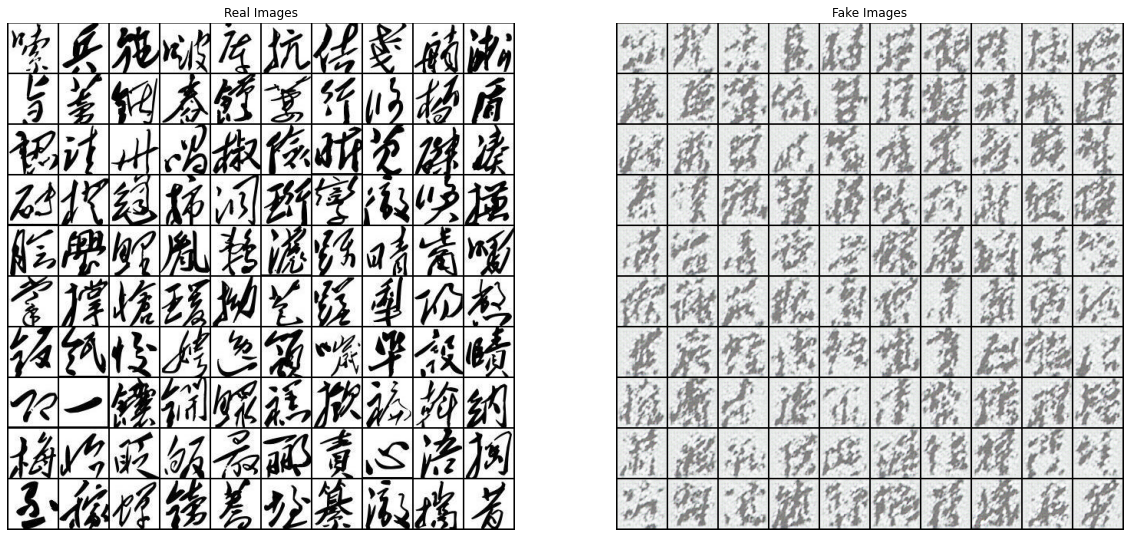

In [9]:
fixex_noise = torch.randn(100, 100, 1, 1, device=device)
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
real = next(iter(dataloader))
plt.imshow(make_grid(real[0][:100], nrow=10).permute(1, 2, 0))

netG = Generator()
netG.load_state_dict(torch.load('gan_pth', map_location=torch.device('cpu')))
netG.eval()

with torch.no_grad():
    fake = netG(fixex_noise.cpu())

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
fake = make_grid(fake*0.5+0.5, nrow=10)
plt.imshow(fake.permute(1, 2, 0))

plt.savefig('result2.jpg', bbox_inches='tight')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


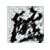

In [16]:
device=torch.device('cuda'if torch.cuda.is_available() else "cpu")
fixex_noise = torch.randn(1, 100, 1, 1, device=device)
with torch.no_grad():
    fake = netG(fixex_noise.cpu())
fake = make_grid(fake)
plt.figure(figsize=(0.67, 0.67))
plt.axis("off")
plt.imshow(fake.permute(1, 2, 0))
plt.savefig('mzd1.jpg',dpi=96)